## Simulation 1

In [1]:
%matplotlib widget

# Environment Setup & Training

In [ ]:
# ----- DEPENDENCIES -----

import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rich
from pathlib import Path
from floris.flow_visualization import visualize_cut_plane
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.noise import NormalActionNoise
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from floris import FlorisModel
import torch

# ----- ENV SETUP -----

class FlorisEnv(gym.Env):
    def __init__(self, config_path):
        super(FlorisEnv, self).__init__()
        self.fmodel = FlorisModel(config_path)
        
        # Setup Farm Layout
        D = 126.0
        self.x_layout = [0, 0, 6 * D, 6 * D]
        self.y_layout = [0, 3 * D, 0, 3 * D]
        self.fmodel.set(layout_x=self.x_layout, layout_y=self.y_layout)
        self.n_turbines = len(self.x_layout)
        
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.n_turbines,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([270.0, 8.0, 0.05]), 
            high=np.array([280.0, 11.0, 0.20]), 
            dtype=np.float32
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_wd = np.random.uniform(270.0, 280.0)
        self.current_ws = np.random.uniform(8.0, 11.0)
        self.current_ti = np.random.uniform(0.05, 0.20)
        return np.array([self.current_wd, self.current_ws, self.current_ti], dtype=np.float32), {}

    def step(self, action):
        yaw_angles = action * 25.0
        
        # Baseline
        self.fmodel.set(wind_directions=[self.current_wd], wind_speeds=[self.current_ws], 
                        turbulence_intensities=[self.current_ti], yaw_angles=np.zeros((1, self.n_turbines)))
        self.fmodel.run()
        baseline_mw = np.sum(self.fmodel.get_turbine_powers()) / 1e6

        # Control
        self.fmodel.set(yaw_angles=np.array([yaw_angles]))
        self.fmodel.run()
        rl_mw = np.sum(self.fmodel.get_turbine_powers()) / 1e6
        
        gain_pct = 100 * (rl_mw - baseline_mw) / baseline_mw
        obs = np.array([self.current_wd, self.current_ws, self.current_ti], dtype=np.float32)
        
        return obs, rl_mw, True, False, {"baseline_kw": baseline_mw * 1000, "power_kw": rl_mw * 1000, "gain_pct": gain_pct}

# Initialize Env (Update this path to your actual yaml file)
CONFIG_PATH = "data_generation/farm_types/gch.yaml" 
env = FlorisEnv(CONFIG_PATH)

# ----- TRAINING -----
def run_training(algo="PPO", steps=10000):    
    log_path = "./tensorboard_logs_test_controllers/"
    if algo == "PPO":
        model = PPO("MlpPolicy", env, verbose=0, 
                    tensorboard_log=log_path) 
    else:
        n_actions = env.action_space.shape[-1]
        noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
        model = DDPG("MlpPolicy", env, action_noise=noise, verbose=0, 
                     tensorboard_log=log_path) 
    
    print(f" Training {algo} and logging to {log_path}...")
    
    model.learn(
        total_timesteps=steps, 
        tb_log_name=f"{algo}_run", # This creates a subfolder like PPO_run_1
        progress_bar=False,
    )
    return model

ppo_model = run_training("PPO", 20000)
ddpg_model = run_training("DDPG", 20000)

/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


 Training PPO and logging to ./tensorboard_logs_test_controllers/...


/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/floris/core/flow_field.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  * np.power(


 Training DDPG and logging to ./tensorboard_logs_test_controllers/...


In [4]:

from stable_baselines3 import SAC
sac_model = run_training("SAC", 20000)

 Training SAC and logging to ./tensorboard_logs_test_controllers/...


/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/floris/core/flow_field.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  * np.power(


# Evaluate

/opt/anaconda3/envs/floris312/lib/python3.12/site-packages/floris/core/flow_field.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  * np.power(


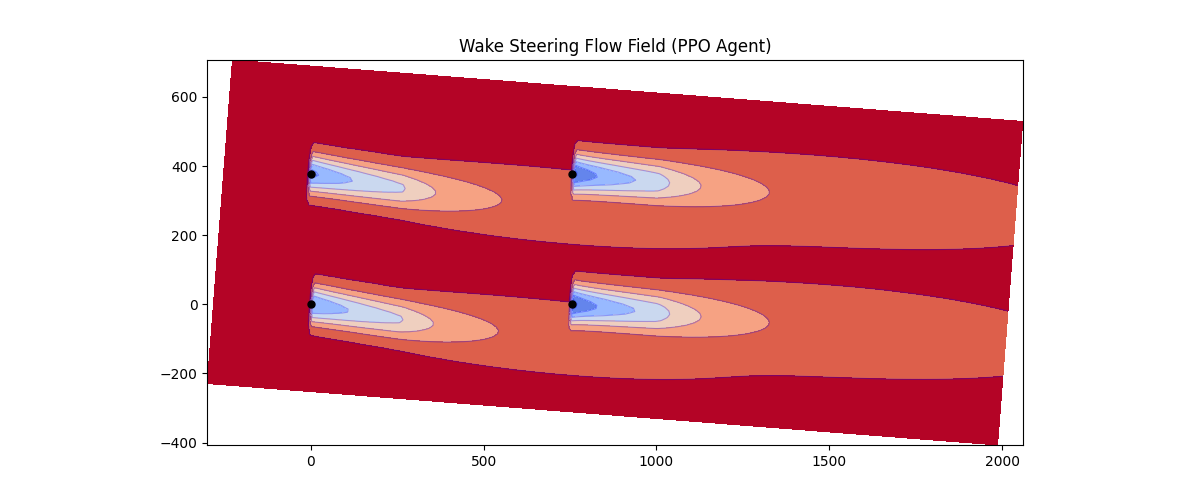

In [5]:
def compare_agents(models, n_episodes=30):
    results = []
    for i in range(n_episodes):
        obs, _ = env.reset()
        # Baseline check
        _, _, _, _, info_base = env.step(np.zeros(env.n_turbines))
        
        data = {"Episode": i, "Baseline": info_base['power_kw']}
        for name, model in models.items():
            action, _ = model.predict(obs, deterministic=True)
            _, _, _, _, info = env.step(action)
            data[name] = info['power_kw']
            data[f"{name}_Gain%"] = info['gain_pct']
        results.append(data)
    
    return pd.DataFrame(results)

df_results = compare_agents({"PPO": ppo_model, "DDPG": ddpg_model, "SAC": sac_model})


# 1. Setup a specific test case
obs, _ = env.reset()
# Let's say we want to visualize the PPO agent's decision
action, _ = ppo_model.predict(obs, deterministic=True)
yaw_angles = action * 25.0

# 2. Update FLORIS model with the chosen yaw
env.fmodel.set(yaw_angles=np.array([yaw_angles]))
env.fmodel.run()

# 3. Calculate a horizontal plane at hub height
# height=90.0 is typical, or use env.fmodel.core.farm.hub_heights[0]
hor_plane = env.fmodel.calculate_horizontal_plane(
    x_resolution=200, 
    y_resolution=100, 
    height=90.0 
)

# 4. Plot the flow field
fig, ax = plt.subplots(figsize=(12, 5))
visualize_cut_plane(hor_plane, ax=ax, title="Wake Steering Flow Field (PPO Agent)")

# Add turbine markers to the plot
for x, y in zip(env.x_layout, env.y_layout):
    ax.plot(x, y, "ko", markersize=5) 

plt.show()

def plot_behavior_analysis(df_results):
    # We want to see how Yaw Action correlates with Wind Direction
    plt.figure(figsize=(10, 6))
    
    # Plotting how the first turbine (the main wake maker) yaws relative to wind direction
    sns.scatterplot(data=df_results, x='Wind_Direction', y='Turbine_0_Yaw', hue='PPO_Gain%')
    plt.title("Agent Strategy: Turbine 0 Yaw vs. Wind Direction")
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True, alpha=0.3)
    plt.show()

# (Ensure your evaluation loop saves 'Wind_Direction' and 'Turbine_0_Yaw' into the results DF)

def compare_wake_plots(env, models, test_obs):
    fig, axes = plt.subplots(len(models), 1, figsize=(12, 5 * len(models)))
    
    # Standard wind condition for comparison
    wd, ws, ti = test_obs
    
    for i, (name, model) in enumerate(models.items()):
        action, _ = model.predict(test_obs, deterministic=True)
        yaw_angles = action * 25.0
        
        env.fmodel.set(wind_directions=[wd], wind_speeds=[ws], 
                        turbulence_intensities=[ti], yaw_angles=np.array([yaw_angles]))
        env.fmodel.run()
        
        hor_plane = env.fmodel.calculate_horizontal_plane(height=90.0)
        visualize_cut_plane(hor_plane, ax=axes[i], title=f"{name} Strategy (Yaw: {np.round(yaw_angles, 1)})")
        
    plt.tight_layout()
    plt.show()

# Usage:
# test_obs, _ = env.reset()
# compare_wake_plots(env, {"PPO": ppo_model, "DDPG": ddpg_model}, test_obs)

next steps: validation script